# Deep Learning -BiLSTM

In [1]:
import os
import pandas as pd
import re
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.stem import WordNetLemmatizer
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from gensim.models import KeyedVectors
from gensim.downloader import load as gensim_load
from sklearn.metrics import confusion_matrix, classification_report
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords


2025-05-30 05:31:43.534203: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748583103.734620      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748583103.792361      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# Load the dataset
df = pd.read_csv("/kaggle/input/dataset1/D1.csv")

In [3]:
# Drop the unnecessary column if it exists
if 'Unnamed: 0' in df.columns:
    df.drop('Unnamed: 0', axis=1, inplace=True)

In [4]:
# Drop rows with missing values
df.dropna(inplace=True)
print("\nShape after dropping missing values:", df.shape)


Shape after dropping missing values: (52681, 2)


In [5]:
# Check the distribution of 'status' before resampling
print("\nStatus Value Counts before resampling:")
print(df['status'].value_counts())



Status Value Counts before resampling:
status
Normal                  16343
Depression              15404
Suicidal                10652
Anxiety                  3841
Bipolar                  2777
Stress                   2587
Personality disorder     1077
Name: count, dtype: int64


In [6]:
#  Resampling to Balance Classes
def resample_data(df):
    max_count = df['status'].value_counts().max()
    df_resampled = pd.DataFrame()
    for status in df['status'].unique():
        df_class = df[df['status'] == status]
        if len(df_class) < max_count:
            df_class_resampled = resample(df_class, replace=True, n_samples=max_count, random_state=42)
            df_resampled = pd.concat([df_resampled, df_class_resampled])
        else:
            df_resampled = pd.concat([df_resampled, df_class])
    return df_resampled

df = resample_data(df)
print("Value counts after resampling:")
print(df['status'].value_counts())

Value counts after resampling:
status
Anxiety                 16343
Normal                  16343
Depression              16343
Suicidal                16343
Stress                  16343
Bipolar                 16343
Personality disorder    16343
Name: count, dtype: int64


In [7]:
# Text Preprocessing
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text.lower())
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

df['statement'] = df['statement'].apply(preprocess_text)
print("\nSample preprocessed text:")
print(df['statement'].head())


Sample preprocessed text:
52349    must find something wrong relationship girlfri...
52697    water slide going sound stupid lol basically g...
34039    insomnia last month suddenly developed worst c...
34473    tired wasting money time know nothing wrong im...
34309    head nodding tic cause long term damage hey iv...
Name: statement, dtype: object


In [8]:
# Splitting Data and Encoding Labels
X = df['statement'].values
y = df['status'].values

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Training set shape: (91520,) (91520, 7)
Testing set shape: (22881,) (22881, 7)


In [9]:
# Tokenization and Padding
max_words = 50000
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

max_sequence_length = 100
X_train_padded = pad_sequences(X_train_seq, maxlen=max_sequence_length, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_sequence_length, padding='post', truncating='post')
print("Padded Training Data Shape:", X_train_padded.shape)
print("Padded Testing Data Shape:", X_test_padded.shape)

Padded Training Data Shape: (91520, 100)
Padded Testing Data Shape: (22881, 100)


In [ ]:
# Loading Pre-trained Word2Vec via Gensim Downloader
print("Downloading the pre-trained Google News Word2Vec model. This may take a while...")
word2vec_model = gensim_load("word2vec-google-news-300")
embedding_dim = word2vec_model.vector_size  
print("Download complete. Embedding dimension:", embedding_dim)

[=================---------------------------------] 35.1% 582.9/1662.8MB downloaded

In [ ]:
# Building the Embedding Matrix with Fine-Tuning Enabled
word_index = tokenizer.word_index
num_words = min(max_words, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, embedding_dim))
found_count = 0

for word, i in word_index.items():
    if i >= max_words:
        continue
    if word in word2vec_model:
        embedding_matrix[i] = word2vec_model[word]
        found_count += 1
    else:
        # Initialize missing words with random vectors
        embedding_matrix[i] = np.random.normal(scale=0.6, size=(embedding_dim,))

print(f"Found embeddings for {found_count} out of {num_words} words.")

In [ ]:
# Building the BiLSTM Model (with Fine-Tuning)
lstm_units = 64
num_classes = y_categorical.shape[1]

model = Sequential([
    Embedding(input_dim=num_words, 
              output_dim=embedding_dim, 
              input_length=max_sequence_length,
              weights=[embedding_matrix],
              trainable=True),  # Now set to True for fine-tuning
    Bidirectional(LSTM(units=lstm_units, dropout=0.2, recurrent_dropout=0.2)),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

In [13]:
# Training the Model
history = model.fit(X_train_padded, y_train,
                    epochs=10,           
                    batch_size=128,      
                    validation_data=(X_test_padded, y_test))

715/715 ━━━━━━━━━━━━━━━━━━━━ 220s 294ms/step - accuracy: 0.5761 - loss: 1.1355 - val_accuracy: 0.8556 - val_loss: 0.3988
Epoch 2/10
715/715 ━━━━━━━━━━━━━━━━━━━━ 210s 294ms/step - accuracy: 0.8584 - loss: 0.3936 - val_accuracy: 0.9026 - val_loss: 0.2702
Epoch 3/10
715/715 ━━━━━━━━━━━━━━━━━━━━ 209s 292ms/step - accuracy: 0.9171 - loss: 0.2409 - val_accuracy: 0.9226 - val_loss: 0.2240
Epoch 4/10
715/715 ━━━━━━━━━━━━━━━━━━━━ 210s 294ms/step - accuracy: 0.9483 - loss: 0.1569 - val_accuracy: 0.9311 - val_loss: 0.2081
Epoch 5/10
715/715 ━━━━━━━━━━━━━━━━━━━━ 211s 294ms/step - accuracy: 0.9639 - loss: 0.1111 - val_accuracy: 0.9372 - val_loss: 0.2009
Epoch 6/10
715/715 ━━━━━━━━━━━━━━━━━━━━ 210s 293ms/step - accuracy: 0.9735 - loss: 0.0860 - val_accuracy: 0.9385 - val_loss: 0.2170
Epoch 7/10
715/715 ━━━━━━━━━━━━━━━━━━━━ 209s 293ms/step - accuracy: 0.9786 - loss: 0.0663 - val_accuracy: 0.9426 - val_loss: 0.2280
Epoch 8/10
715/715 ━━━━━━━━━━━━━━━━━━━━ 210s 293ms/step - accuracy: 0.9824 - loss: 0.05

In [14]:
# Evaluating the Model
test_loss, test_accuracy = model.evaluate(X_test_padded, y_test)
print("\nTest Accuracy: {:.2f}%".format(test_accuracy * 100))


716/716 ━━━━━━━━━━━━━━━━━━━━ 56s 78ms/step - accuracy: 0.9438 - loss: 0.2808

Test Accuracy: 94.39%


716/716 ━━━━━━━━━━━━━━━━━━━━ 57s 78ms/step
Confusion Matrix:
[[3295    3   20   10    0    0    3]
 [   3 3174    7    0    0    8    1]
 [  24   15 2724   69    5   21  454]
 [  23    5   63 3031    2   56   80]
 [   0    0    0    0 3186    0    0]
 [   0    0    7   10    0 3241    1]
 [   3    7  292   81    0   11 2946]]


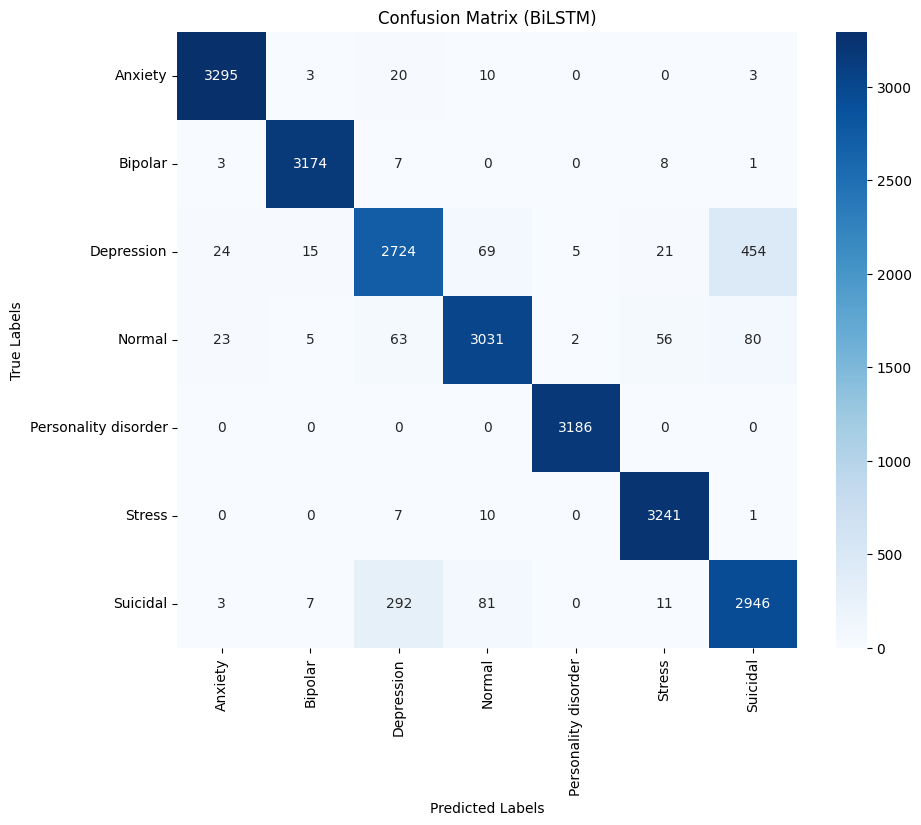

Classification Report:
                      precision    recall  f1-score   support

             Anxiety     0.9842    0.9892    0.9867      3331
             Bipolar     0.9906    0.9940    0.9923      3193
          Depression     0.8750    0.8225    0.8479      3312
              Normal     0.9469    0.9298    0.9382      3260
Personality disorder     0.9978    1.0000    0.9989      3186
              Stress     0.9712    0.9945    0.9827      3259
            Suicidal     0.8453    0.8820    0.8633      3340

            accuracy                         0.9439     22881
           macro avg     0.9444    0.9446    0.9443     22881
        weighted avg     0.9438    0.9439    0.9436     22881



In [15]:
# Generating Predictions and Evaluation Metrics
y_pred_probs = model.predict(X_test_padded)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (BiLSTM)')
plt.show()

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_, digits=4))

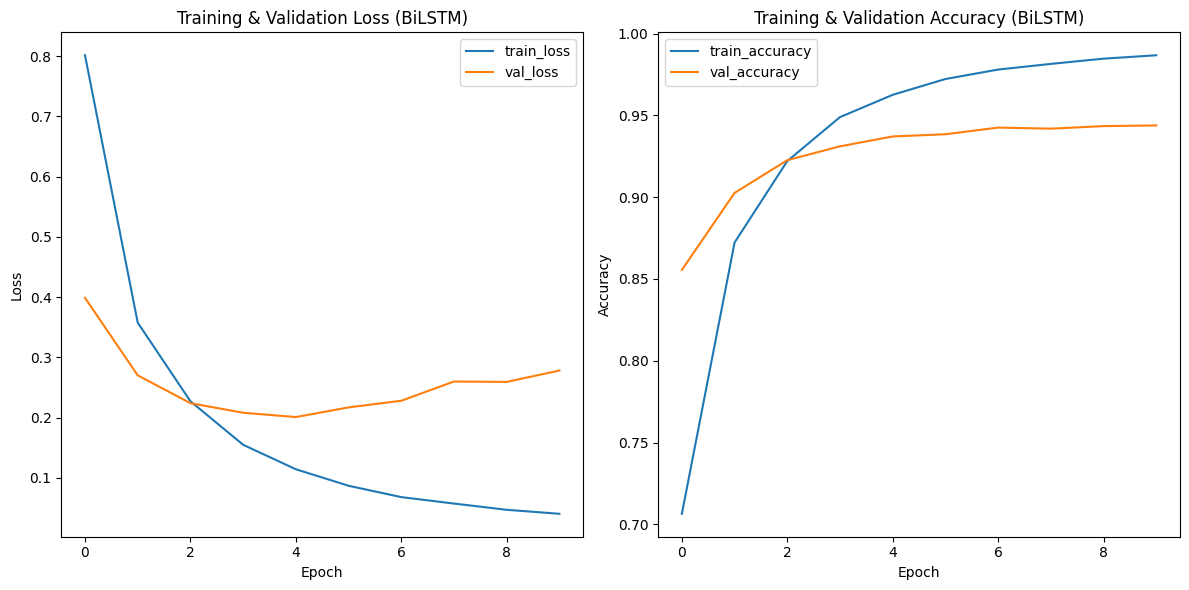

In [16]:
# Plot training & validation loss and accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Training & Validation Loss (BiLSTM)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Training & Validation Accuracy (BiLSTM)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

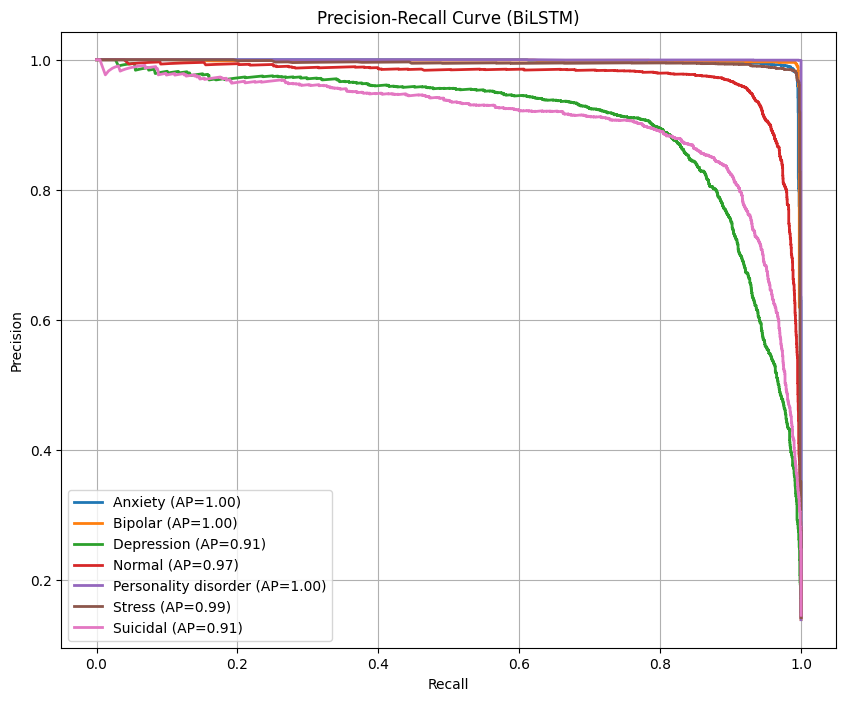

In [17]:
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize

# Binarize true labels for multi-class PR curve
y_test_bin = label_binarize(y_true, classes=np.arange(num_classes))
precision = dict()
recall = dict()
avg_precision = dict()

plt.figure(figsize=(10, 8))
for i in range(num_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_pred_probs[:, i])
    avg_precision[i] = average_precision_score(y_test_bin[:, i], y_pred_probs[:, i])
    plt.plot(recall[i], precision[i], lw=2, label=f'{label_encoder.classes_[i]} (AP={avg_precision[i]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (BiLSTM)')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()


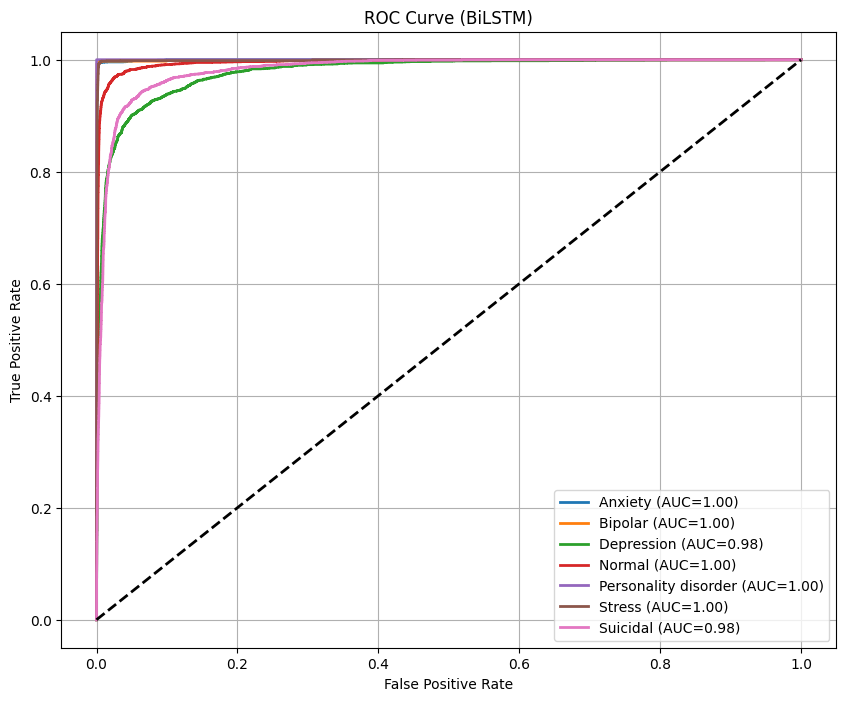

In [18]:
# ROC Curve
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()

plt.figure(figsize=(10, 8))
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], lw=2, label=f'{label_encoder.classes_[i]} (AUC={roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (BiLSTM)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

